In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
from mistune.plugins.math import math
from pyspark.sql.functions import avg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dataset_base_path = r'E:\PycharmProjects\pythonProject1\iiot2024'


In [3]:
types = {
    'ts': 'float64',  # Timestamp, likely in float format
    'flow_duration': 'float32',  # Same as original
    'Header_Length': 'int64',  # Same as original 'header_length'
    'Source IP': 'object',  # IP addresses as strings
    'Destination IP': 'object',  # IP addresses as strings
    'Source Port': 'int32',  # Ports can be stored as integers
    'Destination Port': 'int32',  # Same as source port
    'Protocol Type': 'int8',  # Assuming small integer range for protocol types
    'Protocol_name': 'object',  # Protocol names as strings
    'Duration': 'float32',  # Same as original 'duration'
    'Rate': 'float32',  # Replacing 'rate'
    'Srate': 'float32',  # Same as original 'srate'
    'Drate': 'float32',  # Same as original 'drate'
    'fin_flag_number': 'uint8',  # Same as original
    'syn_flag_number': 'uint8',  # Same as original
    'rst_flag_number': 'uint8',  # Same as original
    'psh_flag_number': 'uint8',  # Same as original
    'ack_flag_number': 'uint8',  # Same as original
    'urg_flag_number': 'uint8',  # New, inferred from context
    'ece_flag_number': 'uint8',  # Same as original
    'cwr_flag_number': 'uint8',  # Same as original
    'ack_count': 'float32',  # Same as original
    'syn_count': 'float32',  # Same as original
    'fin_count': 'float32',  # Same as original
    'urg_count': 'float32',  # Same as original
    'rst_count': 'float32',  # Same as original
    'max_duration': 'float32',  # New field inferred from context
    'min_duration': 'float32',  # New field inferred from context
    'sum_duration': 'float32',  # New field inferred from context
    'average_duration': 'float32',  # New field inferred from context
    'std_duration': 'float32',  # New field inferred from context
    'CoAP': 'uint8',  # New field, protocol flag
    'HTTP': 'uint8',  # Protocol flag
    'HTTPS': 'uint8',  # Protocol flag
    'DNS': 'uint8',  # Protocol flag
    'Telnet': 'uint8',  # Protocol flag
    'SMTP': 'uint8',  # Protocol flag
    'SSH': 'uint8',  # Protocol flag
    'IRC': 'uint8',  # Protocol flag
    'TCP': 'uint8',  # Protocol flag
    'UDP': 'uint8',  # Protocol flag
    'DHCP': 'uint8',  # Protocol flag
    'ARP': 'uint8',  # Protocol flag
    'ICMP': 'uint8',  # Protocol flag
    'IGMP': 'uint8',  # Protocol flag
    'IPv': 'uint8',  # Protocol flag
    'LLC': 'uint8',  # Protocol flag
    'Tot sum': 'float32',  # Replacing 'tot_sum'
    'Min': 'float32',  # Replacing 'min'
    'Max': 'float32',  # Replacing 'max'
    'AVG': 'float32',  # Replacing 'avg'
    'Std': 'float32',  # Replacing 'std'
    'Tot size': 'float32',  # Replacing 'tot_size'
    'IAT': 'float32',  # Replacing 'iat'
    'Number': 'float32',  # Replacing 'number'
    'MAC': 'object',  # Likely MAC address, stored as a string
    'Magnitue': 'float32',  # Inferred from context
    'Radius': 'float32',  # Same as original 'radius'
    'Covariance': 'float32',  # Same as original 'covariance'
    'Variance': 'float32',  # Same as original 'variance'
    'Weight': 'float32',  # Same as original 'weight'
    'DS status': 'uint8',  # New field, inferred from context
    'Fragments': 'uint8',  # New field, inferred from context
    'Sequence number': 'int64',  # New field, inferred from context
    'Protocol Version': 'int8',  # New field, inferred from context
    'flow_idle_time': 'float32',  # New field, inferred from context
    'flow_active_time': 'float32',  # New field, inferred from context
    'label': 'object',  # Same as original
    'subLabel': 'object',  # New field, inferred from context
    'subLabelCat': 'object'  # New field, inferred from context
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values

    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))

    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)


    return df

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
df

,ts,flow_duration,Header_Length,Source IP,Destination IP,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,...,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,label,subLabel,subLabelCat
0,1.701426e+09,0.000000,66,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,1.0,0,0,0,0,1.701426e+09,0.000000,0,0,0
1,1.701426e+09,0.002112,132,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,4.0,0,0,0,0,2.112150e-03,0.002112,0,0,0
2,1.701426e+09,0.002328,198,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,9.0,0,0,0,0,2.160072e-04,0.002328,0,0,0
3,1.701426e+09,0.004329,264,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,16.0,0,0,0,0,2.001047e-03,0.004329,0,0,0
4,1.701426e+09,0.009495,330,172.16.64.128,172.16.66.128,41750,502,6,TCP,64.0,...,25.0,0,0,0,0,5.165815e-03,0.009495,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,100.0,0,0,0,0,2.312660e-05,2.018212,0,0,0
9536819,1.701550e+09,0.021296,1432,172.16.66.128,172.16.64.128,502,55784,6,TCP,64.0,...,121.0,0,0,0,0,2.112150e-03,0.021296,0,0,0
9536820,1.701550e+09,2.018227,5670,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,144.0,0,0,0,0,1.478195e-05,2.018227,0,0,0
9536821,1.701550e+09,2.018277,5880,172.16.66.128,239.255.255.250,41544,1900,17,UDP,1.0,...,169.0,0,0,0,0,5.006790e-05,2.018277,0,0,0


In [5]:
import socket
import struct
import pandas as pd

def ip_to_int(ip_address):
    try:
        return struct.unpack("!I", socket.inet_aton(ip_address))[0]
    except socket.error:
        return None



df['Source IP (int)'] = df['Source IP'].apply(ip_to_int)
df['Destination IP (int)'] = df['Destination IP'].apply(ip_to_int)

print(df)


                   ts  flow_duration  Header_Length      Source IP  \
0        1.701426e+09       0.000000             66  172.16.64.128   
1        1.701426e+09       0.002112            132  172.16.64.128   
2        1.701426e+09       0.002328            198  172.16.64.128   
3        1.701426e+09       0.004329            264  172.16.64.128   
4        1.701426e+09       0.009495            330  172.16.64.128   
...               ...            ...            ...            ...   
9536818  1.701550e+09       2.018212           5460  172.16.66.128   
9536819  1.701550e+09       0.021296           1432  172.16.66.128   
9536820  1.701550e+09       2.018227           5670  172.16.66.128   
9536821  1.701550e+09       2.018277           5880  172.16.66.128   
9536822  1.701550e+09       2.018348           6090  172.16.66.128   

          Destination IP  Source Port  Destination Port  Protocol Type  \
0          172.16.66.128        41750               502              6   
1          

In [6]:
X = df.drop(columns=['label','subLabel','subLabelCat','Source IP','Destination IP'])
y = df[['label']]

In [7]:
y.label.value_counts()

label
0    21598215
1        1004
Name: count, dtype: int64

In [8]:
X

,ts,flow_duration,Header_Length,Source Port,Destination Port,Protocol Type,Protocol_name,Duration,Rate,Srate,...,Variance,Weight,DS status,Fragments,Sequence number,Protocol Version,flow_idle_time,flow_active_time,Source IP (int),Destination IP (int)
0,1.701426e+09,0.000000,66,41750,502,6,TCP,64.0,0.000000,0.000000,...,0.0,1.0,0,0,0,0,1.701426e+09,0.000000,2886746240,2886746752
1,1.701426e+09,0.002112,132,41750,502,6,TCP,64.0,946.902344,946.902344,...,0.0,4.0,0,0,0,0,2.112150e-03,0.002112,2886746240,2886746752
2,1.701426e+09,0.002328,198,41750,502,6,TCP,64.0,1288.572632,1288.572632,...,0.0,9.0,0,0,0,0,2.160072e-04,0.002328,2886746240,2886746752
3,1.701426e+09,0.004329,264,41750,502,6,TCP,64.0,923.957275,923.957275,...,0.0,16.0,0,0,0,0,2.001047e-03,0.004329,2886746240,2886746752
4,1.701426e+09,0.009495,330,41750,502,6,TCP,64.0,526.591858,526.591858,...,0.0,25.0,0,0,0,0,5.165815e-03,0.009495,2886746240,2886746752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536818,1.701550e+09,2.018212,5460,41544,1900,17,UDP,1.0,12.882689,12.882689,...,1.0,100.0,0,0,0,0,2.312660e-05,2.018212,2886746752,4026531834
9536819,1.701550e+09,0.021296,1432,502,55784,6,TCP,64.0,939.142456,939.142456,...,1.0,121.0,0,0,0,0,2.112150e-03,0.021296,2886746752,2886746240
9536820,1.701550e+09,2.018227,5670,41544,1900,17,UDP,1.0,13.378079,13.378079,...,1.0,144.0,0,0,0,0,1.478195e-05,2.018227,2886746752,4026531834
9536821,1.701550e+09,2.018277,5880,41544,1900,17,UDP,1.0,13.873220,13.873220,...,1.0,169.0,0,0,0,0,5.006790e-05,2.018277,2886746752,4026531834


In [9]:
y.value_counts()

label
0        21598215
1            1004
Name: count, dtype: int64

In [10]:
selected_features = [
    'ts', 'flow_duration', 'Source Port', 'Destination Port', 'Protocol Type', 'Duration', 'Rate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'syn_count', 'urg_count', 'HTTP', 'HTTPS', 'DNS', 'SSH', 'TCP', 'ARP', 'ICMP', 'IGMP', 'IPv',
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Variance', 'Source IP (int)', 'Destination IP (int)'
]

In [11]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 33


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



In [65]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score


from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score


# Initialize the XGBoost model
# Initialize the XGBoost model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='gpu_hist',
    max_depth=9,
    learning_rate=0.1,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1
)

`use_label_encoder` is deprecated in 1.7.0.


In [66]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [67]:
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [68]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.9999981480812733
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4319643
           1       1.00      0.96      0.98       201

    accuracy                           1.00   4319844
   macro avg       1.00      0.98      0.99   4319844
weighted avg       1.00      1.00      1.00   4319844



In [69]:
class_names = [
    "0",
    "1"

]


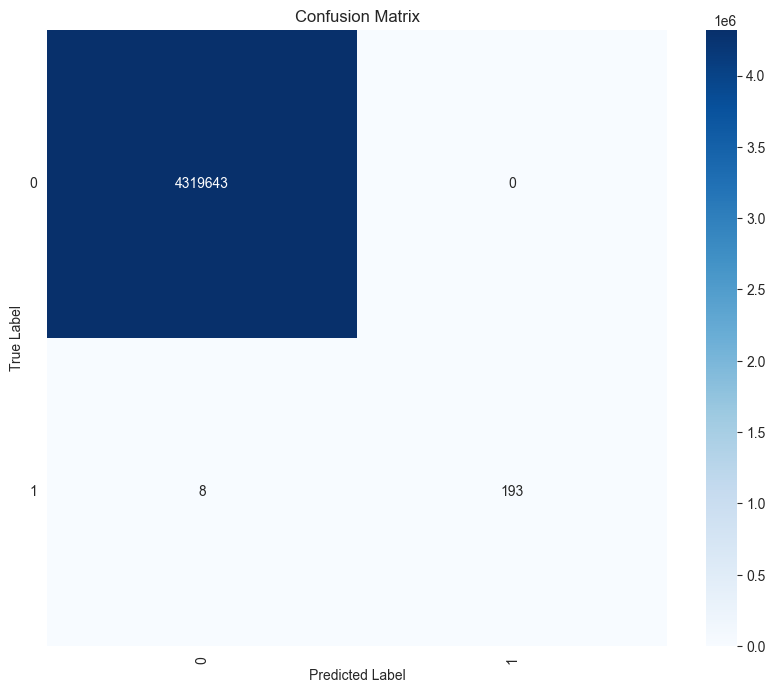

In [70]:
from sklearn.metrics import confusion_matrix


# Ensure y_test has the same type as y_pred
y_test = y_test.astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)  # Rotate X-axis labels for readability if they are long
plt.yticks(rotation=0)
plt.show()


In [73]:
target_names = [      0,1
]


In [74]:
from prettytable import PrettyTable
from sklearn.metrics import precision_recall_fscore_support

def display_metrics_table(y_true, y_pred):
    # Convert y_true to numpy array if it's a DataFrame
    if hasattr(y_true, 'values'):
        y_true = y_true.values

    # Flatten y_true to match the shape of y_pred
    y_true = y_true.ravel()

    # Convert y_true to integers to match y_pred
    y_true = y_true.astype(int)

    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

    # Create a table
    table = PrettyTable()
    table.field_names = ["Class", "Precision", "Recall", "F1-score", "Support"]

    for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
        table.add_row([f"Class {i}", f"{p:.6f}", f"{r:.6f}", f"{f:.6f}", s])

    print(table)

    # Calculate accuracy
    accuracy = (y_pred == y_true).sum() / len(y_true)
    print(f"\nOverall Accuracy: {accuracy:.6f}")

# Convert y_test to a numpy array if necessary, and flatten it
if hasattr(y_test, 'values'):
    y_test = y_test.values

y_test = y_test.ravel()

# Convert y_test from strings to integers
y_test = y_test.astype(int)

y_pred = model.predict(X_test).ravel()
y_pred = y_pred.astype(int)

display_metrics_table(y_test, y_pred)


+---------+-----------+----------+----------+---------+
|  Class  | Precision |  Recall  | F1-score | Support |
+---------+-----------+----------+----------+---------+
| Class 0 |  0.999998 | 1.000000 | 0.999999 | 4319643 |
| Class 1 |  1.000000 | 0.960199 | 0.979695 |   201   |
+---------+-----------+----------+----------+---------+

Overall Accuracy: 0.999998


In [75]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def calculate_latency(model, X_test,  iterations=10):
  """
    Average Prediction Latency Per Sample.


    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      iterations: Number of iterations to average latency over.
    Returns:
      average_latency_per_row: The average latency per row across all iterations
  """
  total_latency = 0
  num_rows = X_test.shape[0]

  for _ in range(iterations):
      start_time = time.time()

      # Data Preparation (Dummy Preprocessing as example, replace with your processing pipeline)
      X_test_prep = X_test.copy() # This represents your preprocessing, you can scale as you did in your code if you want.

      # Prediction step
      model.predict(X_test_prep)

      end_time = time.time()
      total_latency += (end_time - start_time)

  average_latency = total_latency / iterations
  average_latency_per_row = average_latency / num_rows
  return average_latency_per_row

In [79]:
average_latency_cat = calculate_latency(model, X_test)
average_latency_cat

8.128127418548183e-07

In [80]:
import psutil
import os
import time

def measure_prediction_memory_cost(model, X_test):
    """
    Memory Usage During Prediction on Test Set (MB)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
    Returns:
      memory_usage_mb: The increase in memory usage during the prediction, in MB.
    """
    def get_memory_usage():
        process = psutil.Process(os.getpid())
        return process.memory_info().rss / (1024 ** 2)  # in MB

    start_memory = get_memory_usage()
    model.predict(X_test)
    end_memory = get_memory_usage()

    memory_usage_mb = end_memory - start_memory
    return memory_usage_mb



In [114]:
memory_cost = measure_prediction_memory_cost(model, X_test)
print(f"Memory usage during prediction: {memory_cost:.2f} MB")

Memory usage during prediction: 0.02 MB


In [116]:
import psutil
import os
import time

def measure_prediction_cpu_cost(model, X_test, duration=3):
    """
    Average CPU Usage During Prediction on Test Set (%)
    System CPU time during prediction on  Test Set (seconds)

    Args:
      model: Trained model with .predict method.
      X_test: Test data.
      duration : time in seconds to average cpu metrics over.
    Returns:
        cpu_percent: Average CPU usage percentage during prediction.
        user_cpu_time: User CPU time in seconds during the prediction.
        system_cpu_time: System CPU time in seconds during the prediction.
    """

    def get_cpu_usage():
      cpu_percent = psutil.cpu_percent()
      cpu_times = psutil.cpu_times()
      return cpu_percent, cpu_times.user, cpu_times.system

    cpu_usage_list = []
    user_cpu_time_list = []
    system_cpu_time_list = []

    start_time = time.time()
    while time.time() - start_time <= duration:
      cpu_percent, user_time, system_time = get_cpu_usage()
      cpu_usage_list.append(cpu_percent)
      user_cpu_time_list.append(user_time)
      system_cpu_time_list.append(system_time)
      time.sleep(0.1) # Check cpu every 0.1 second

    start_cpu_percent, start_user_time, start_system_time = get_cpu_usage()

    start_prediction_time = time.time()
    model.predict(X_test)
    end_prediction_time = time.time()

    cpu_percent, end_user_time, end_system_time = get_cpu_usage()

    total_user_time = end_user_time - start_user_time
    total_system_time = end_system_time - start_system_time

    return np.mean(cpu_usage_list), total_user_time, total_system_time




In [117]:
cpu_percent, user_cpu_time, system_cpu_time = measure_prediction_cpu_cost(model, X_test)
print(f"Average CPU usage during prediction: {cpu_percent:.2f}%")
print(f"User CPU time during prediction: {user_cpu_time:.2f} seconds")
print(f"System CPU time during prediction: {system_cpu_time:.2f} seconds")

Average CPU usage during prediction: 3.38%
User CPU time during prediction: 58.45 seconds
System CPU time during prediction: 1.88 seconds


In [102]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import psutil
import os

def measure_prediction_scalability(model, X, y, test_size = 0.2, sizes = np.linspace(0.1, 1, 10), iterations = 3):
    """
    Measures scalability

    Args:
      model: Trained model with .predict method.
      X: Full Input dataframe.
      y: Full labels of the dataframe.
      test_size: size of the test set.
      sizes: Fractions of test data to evaluate over.
      iterations: Number of iterations to average over.
    Returns:
      sizes: Fraction of test data used in each run
      prediction_times: time taken to do predictions with each fraction of test data
    """
    prediction_times = []
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_size, random_state=42)

    for size in sizes:
        subset_size = int(len(X_test1) * size)
        X_test_subset = X_test1[:subset_size]


        total_prediction_time = 0
        for _ in range(iterations):
             start_time = time.time()
             model.predict(X_test_subset)
             end_time = time.time()
             total_prediction_time += (end_time-start_time)
        prediction_time = total_prediction_time/iterations


        prediction_times.append(prediction_time)

    return sizes, prediction_times




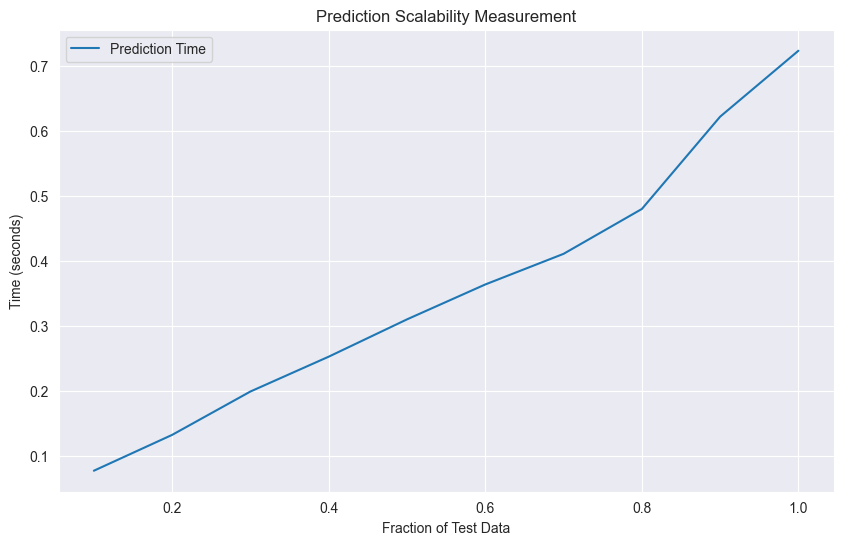

In [106]:
sizes, prediction_times = measure_prediction_scalability(model, X_test, y_test)
#
plt.figure(figsize=(10, 6))
plt.plot(sizes, prediction_times, label='Prediction Time')
plt.xlabel('Fraction of Test Data')
plt.ylabel('Time (seconds)')
plt.title('Prediction Scalability Measurement')
plt.legend()
plt.grid(True)
plt.show()